Установка: https://pytorch.org/get-started/locally/

## Сравнение NumPy и PyTorch

Принципы работы в PyTorch немногим отличаются от операций с массивами в NumPy. Рассмотрим следующую функцию ошибки:

$$L=\| y - X\cdot \Theta\|^2_2+\lambda \|\Theta\|_1.$$

Данную функцию можно последовательно реализовать средствами NumPy:

In [6]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
y = np.random.randn(2, 1)
X = np.random.randn(2, 5)
theta = np.random.randn(5, 1)
lmbda = 0.1

pred = X.dot(theta)
pred_loss = np.sum((y - pred) ** 2)
reg_loss = lmbda * np.sum(np.abs(theta))
loss = pred_loss + reg_loss
print(loss)

9.898902694691799


На PyTorch реализация вычисления функции $L$ выглядит аналогично, однако вместо массивов NumPy используются специальные объекты &ndash; `torch.Tensor`. Создать тензор в PyTorch можно как из простого массива, так и из массива Numpy, при этом указав тип данных, содержащихся в тензоре (по умолчанию float32).

Подробнее о типах данных в PyTorch: https://pytorch.org/docs/stable/tensors.html

In [8]:
import torch

In [9]:
y = torch.Tensor(y)
X = torch.Tensor(X)
theta = torch.Tensor(theta).requires_grad_(True) # для theta понадобится вычислить градиент

pred = X.matmul(theta)
pred_loss = torch.sum((y - pred) ** 2)
reg_loss = lmbda * torch.sum(torch.abs(theta))
loss = pred_loss + reg_loss
print(loss)

tensor(9.8989, grad_fn=<AddBackward0>)


In [10]:
print(torch.Tensor([1, 2, 3]).type())
print(torch.Tensor(np.array([1, 2, 3])).type())
print(torch.LongTensor([1, 2, 3]).type())
print(torch.zeros([2, 2, 3], dtype=torch.int64).type())

print(torch.Tensor([[[1, 2, 3], [4, 5, 6]],[[7, 8, 9],[10, 11, 12]]]).size())

torch.FloatTensor
torch.FloatTensor
torch.LongTensor
torch.LongTensor
torch.Size([2, 2, 3])


## Обучение моделей градиентными методами

Обучение моделей в PyTorch производится в цикле. Ниже приведена реализация метода градиентного спуска. Чтобы обучать модели градиентными методами необходимо помнить о том, что на каждой итерации необходимо "обнулять градиенты" (в примере ниже `theta.grad.zero_()`), поскольку по умолчанию PyTorch накапливает градиент, а не вычисляет его заново для текущих значений параметров.

In [11]:
for i in range(10):
    pred = X.matmul(theta)
    pred_loss = torch.sum((y - pred) ** 2)
    reg_loss = lmbda * torch.sum(torch.abs(theta))
    loss = pred_loss + reg_loss

    loss.backward() # вычисляет градиент функции по указанным переменным при их текущих значениях
    theta.data.add_(-0.1*theta.grad.data)
    theta.grad.zero_()

Нижнее подчеркивание у функций перезаписывает значения переменных:

In [12]:
a = torch.Tensor([50, 45, 8])
b = 5

print(a.add(b))
print(a)
print(a.add_(b))
print(a)

tensor([55., 50., 13.])
tensor([50., 45.,  8.])
tensor([55., 50., 13.])
tensor([55., 50., 13.])


## Формирование архитектуры нейронной сети

### Бинарная классификация

В случае бинарной классификации в качестве функции потерь используется, как правило, бинарная кросс-энтропия. Она реализована в PyTorch в виде двух функций: `BCELoss` и `BCEWithLogitsLoss`.

Отличие данных функций состоит в том, что `BCELoss` вычисляет величину ошибки от выхода сети и требует, чтобы в архитектуре явно была указана функция активации на выходном слое. Функция `BCEWithLogitsLoss`, прежде чем вычислять величину потерь, применяет функцию активации (логистическую сигмоиду) к последнему слою, поэтому в архитектуре задавать функцию активации не нужно.

In [13]:
X = torch.FloatTensor(np.random.randn(5, 3))
y = torch.FloatTensor(np.random.randint(0, 2, 5)) # float32

#### Архитектура с `BCELoss`

In [14]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid() # явно задана функция активации
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.BCELoss()

for i in range(100):
    optimizer.zero_grad()
    pred = network(X) # выдает вероятности
    loss = criterion(pred, y.unsqueeze(1)) # размерность pred (5,1), размерность y - (5) 
    loss.backward()
    optimizer.step()

In [15]:
print(pred) # возвращает вероятности

tensor([[0.5854],
        [0.5803],
        [0.5839],
        [0.5873],
        [0.5850]], grad_fn=<SigmoidBackward0>)


#### Пример с `BCEWithLogitsLoss`

In [16]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1) # последний слой - линейный
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.BCEWithLogitsLoss()

for i in range(100):
    optimizer.zero_grad()
    pred = network(X)
    loss = criterion(pred, y.unsqueeze(1)) # размерности для BCEWithLogitsLoss должны совпадать
    loss.backward()
    optimizer.step()

In [17]:
print(pred) # возвращает выход последнего лоинейного слоя
print(torch.sigmoid(pred)) # преобразование в вероятности

tensor([[0.3394],
        [0.3370],
        [0.3391],
        [0.3341],
        [0.3402]], grad_fn=<AddmmBackward0>)
tensor([[0.5840],
        [0.5835],
        [0.5840],
        [0.5828],
        [0.5842]], grad_fn=<SigmoidBackward0>)


### Многоклассовая классификация

Бинарная классификация &ndash; частный случай многоклассовой классификации. Для многоклассовой классификации используется кросс-энтропия. Функция потерь `CrossEntropyLoss` также не требует указания функции активации последним слоем в архитектуре сети.

In [18]:
X = torch.FloatTensor(np.random.randn(5, 3))
y = torch.LongTensor(np.random.randint(0, 2, 5)) # CrossEntropyLoss требует формата int64

In [19]:
y

tensor([0, 0, 0, 0, 1])

In [20]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 2) # на выходном слое 2 нейрона
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss() # применяет softmax к последнему слою и вычисляет ошибку

for i in range(100):
    optimizer.zero_grad()
    pred = network(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

In [21]:
print(torch.softmax(pred, 1)) # преобразование в вероятности

tensor([[0.7694, 0.2306],
        [0.7736, 0.2264],
        [0.7703, 0.2297],
        [0.7715, 0.2285],
        [0.7691, 0.2309]], grad_fn=<SoftmaxBackward0>)


#### Случай нескольких классов

In [22]:
X = torch.FloatTensor(np.random.randn(5, 3))
y = torch.LongTensor(np.random.randint(0, 3, 5))

In [23]:
print(y)

tensor([0, 2, 0, 0, 1])


In [24]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 3) # 3 нейрона, соответствующие 3 классам
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss()

for i in range(100):
    optimizer.zero_grad()
    pred = network(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

In [25]:
print(torch.softmax(pred, 1))

tensor([[0.5520, 0.2327, 0.2152],
        [0.5552, 0.2309, 0.2138],
        [0.5582, 0.2293, 0.2125],
        [0.5573, 0.2309, 0.2118],
        [0.5531, 0.2325, 0.2144]], grad_fn=<SoftmaxBackward0>)


## Оформление архитектуры в виде класса

In [29]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.layer_1 = torch.nn.Linear(3, 20)
        self.layer_2 = torch.nn.Linear(20, 10)
        self.layer_out = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, inputs):
        output_1 = self.sigmoid(self.layer_1(inputs))
        output_2 = self.sigmoid(self.layer_2(output_1))
        output = self.layer_out(output_2)
        
        return output

In [30]:
model = NeuralNetwork()
print(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

NeuralNetwork(
  (layer_1): Linear(in_features=3, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [31]:
X = torch.FloatTensor(np.random.randn(5,3))
y = torch.FloatTensor(np.random.randint(0,2,5))

for i in range(10):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.unsqueeze(1))
    print('iter: ', i+1,' loss: ', loss.item())
    loss.backward()
    optimizer.step()

iter:  1  loss:  0.764582633972168
iter:  2  loss:  0.7205517888069153
iter:  3  loss:  0.6840517520904541
iter:  4  loss:  0.6537677049636841
iter:  5  loss:  0.6286001205444336
iter:  6  loss:  0.6076392531394958
iter:  7  loss:  0.5901381373405457
iter:  8  loss:  0.5754852890968323
iter:  9  loss:  0.5631820559501648
iter:  10  loss:  0.5528212785720825


<div class="alert alert-info">

<h3> Упражнение</h3>
<p></p>
Реализовать в виде класса и обучить модель из предыдущего задания (на данных train_data, train_labels).
 <p></p>
</div>

In [158]:
np.random.seed(67)
points = np.random.uniform(size=(20, 2), low=-1, high=1)
positive = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] >= 0)]
negative = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] < 0)]
train_data = np.vstack([positive, negative])
train_labels = np.hstack([np.ones(positive.shape[0]), np.zeros(negative.shape[0])])

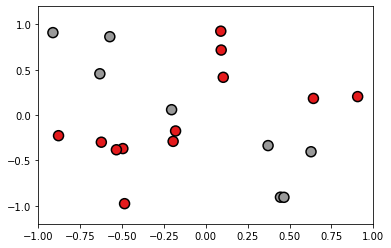

In [159]:
plt.scatter(train_data[:, 0], train_data[:, 1], 
            c=train_labels, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
plt.xlim(-1, 1)
plt.ylim(-1.2, 1.2)
plt.show()

In [160]:
class NeuralNetwork1(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        
        self.layer_1 = torch.nn.Linear(2, 2)
        self.layer_out = torch.nn.Linear(2, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, inputs):
        output_1 = self.sigmoid(self.layer_1(inputs))
        output = self.layer_out(output_1)
        
        return output

In [161]:
model = NeuralNetwork1()
print(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

NeuralNetwork1(
  (layer_1): Linear(in_features=2, out_features=2, bias=True)
  (layer_out): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


<div class="alert alert-info">

<h3> Упражнение</h3>
<p></p>
Для следующих задач сформировать и обучить нейронные сети. Оценить качество сети на отложенной выборке.
 <p></p>
</div>

In [162]:
X = torch.FloatTensor(train_data)
y = torch.FloatTensor(train_labels)
sigm = torch.nn.Sigmoid()

for i in range(10000):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.unsqueeze(1))
    loss.backward()
    optimizer.step()
print('iter: ', 10000,' loss: ', loss.item())

iter:  10000  loss:  0.20165269076824188


### Задача 1

In [137]:
l = 1000
x = np.arange(l) / l
y = 10 * x + np.random.standard_normal(l)

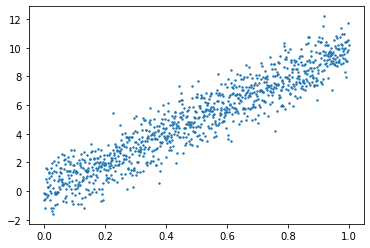

In [138]:
plt.scatter(x, y, s=2)
plt.show()

In [139]:
class NeuralNetworkLinearRegression(torch.nn.Module):
    
    def __init__(self, input_size=1, output_size=1):
        super(NeuralNetworkLinearRegression, self).__init__()
        self.layer_out = torch.nn.Linear(input_size, output_size)
        
    def forward(self, inputs):
        output = self.layer_out(inputs)
        return output

In [140]:
model = NeuralNetworkLinearRegression()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [143]:
X = torch.FloatTensor(x)
y = torch.FloatTensor(y)

for epoch in range(10001):
    optimizer.zero_grad()
    pred = model(X.unsqueeze(1))
    loss = criterion(pred, y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    if not epoch % 1000:
        print('iter: ', epoch,' loss: ', loss.item())

iter:  0  loss:  24.785070419311523
iter:  1000  loss:  1.3679484128952026
iter:  2000  loss:  1.054413080215454
iter:  3000  loss:  1.0318702459335327
iter:  4000  loss:  1.0302492380142212
iter:  5000  loss:  1.0301326513290405
iter:  6000  loss:  1.0301244258880615
iter:  7000  loss:  1.0301238298416138
iter:  8000  loss:  1.0301237106323242
iter:  9000  loss:  1.0301238298416138
iter:  10000  loss:  1.0301238298416138


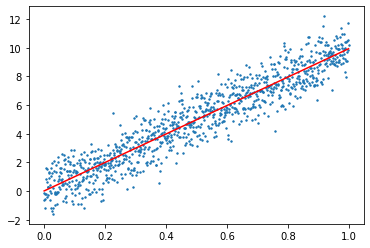

In [144]:
plt.scatter(x, y, s=2)
plt.plot(x, pred.detach().numpy(), color='red')
plt.show()

### Задача 2

In [57]:
x = np.random.uniform(-1, 1, size=(1000, 2))
y = -0.5 * x[:, 0] < 2 * x[:, 1]

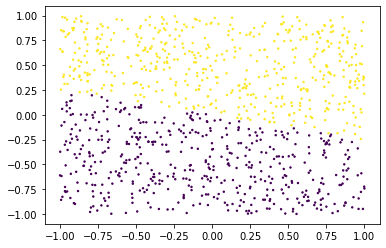

In [58]:
plt.scatter(x[:,0], x[:,1], c=y, s=2)
plt.show()

In [78]:
class NeuralNetworkLogisticRegression(torch.nn.Module):
    
    def __init__(self, input_size=2, output_size=1):
        super(NeuralNetworkLogisticRegression, self).__init__()
        
        self.layer_out = torch.nn.Linear(input_size, output_size)
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, inputs):
        output = self.activation(self.layer_out(inputs))
        return output

In [79]:
model = NeuralNetworkLogisticRegression(2,1)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [87]:
X = torch.FloatTensor(x)
y = torch.FloatTensor(y)

for epoch in range(10001):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    if not epoch % 1000:
        print('iter: ', epoch,' loss: ', loss.item())

iter:  0  loss:  0.1409565508365631
iter:  1000  loss:  0.13571840524673462
iter:  2000  loss:  0.1311589777469635
iter:  3000  loss:  0.1271415501832962
iter:  4000  loss:  0.12356501072645187
iter:  5000  loss:  0.12035281211137772
iter:  6000  loss:  0.11744581162929535
iter:  7000  loss:  0.11479758471250534
iter:  8000  loss:  0.1123710572719574
iter:  9000  loss:  0.11013612151145935
iter:  10000  loss:  0.10806819051504135


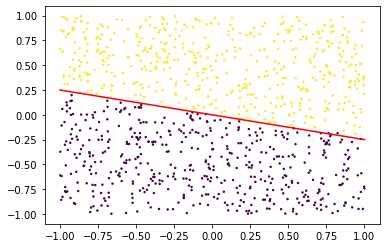

In [88]:
plt.scatter(x[:, 0], x[:, 1], s=2, c=(pred > 0.5))
plt.plot(np.linspace(-1,1,1000), -(0.5/2)*np.linspace(-1,1,1000), c='r')
plt.show()

### Задача 3

In [148]:
x = np.random.uniform(-1, 1, size=(1000, 2))
labels = np.where(
    x[:, 0] > x[:, 1], 0, 
    np.where(
        (x[:, 0] < x[:, 1]) & (-x[:, 0] > x[:, 1]), 
        1, 
        2
    )
)
y = np.zeros((labels.size, labels.max() + 1))
y[np.arange(labels.size), labels] = 1

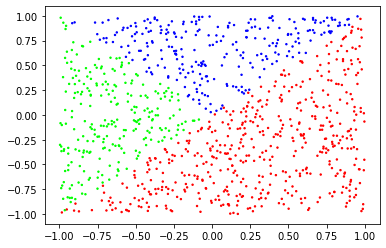

In [149]:
plt.scatter(x[:,0], x[:,1], c=y, s=2)
plt.show()

In [150]:
class NeuralNetworkMulticlassRegression(torch.nn.Module):
    
    def __init__(self, input_size=2, output_size=3):
        super(NeuralNetworkMulticlassRegression, self).__init__()
        
        self.layer_out = torch.nn.Linear(input_size, output_size)
        self.activation = torch.nn.Softmax()
        
    def forward(self, inputs):
        output = self.activation(self.layer_out(inputs))
        return output

In [151]:
model = NeuralNetworkLogisticRegression(2,3)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2)

In [152]:
X = torch.FloatTensor(x)
y = torch.FloatTensor(y)

for epoch in range(20001):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    if not epoch % 1000:
        print('iter: ', epoch,' loss: ', loss.item())

iter:  0  loss:  0.7621384263038635
iter:  1000  loss:  0.19306693971157074
iter:  2000  loss:  0.18678368628025055
iter:  3000  loss:  0.18375536799430847
iter:  4000  loss:  0.18183887004852295
iter:  5000  loss:  0.18047013878822327
iter:  6000  loss:  0.17942214012145996
iter:  7000  loss:  0.17858237028121948
iter:  8000  loss:  0.17788761854171753
iter:  9000  loss:  0.1772988885641098
iter:  10000  loss:  0.17679081857204437
iter:  11000  loss:  0.1763458400964737
iter:  12000  loss:  0.17595145106315613
iter:  13000  loss:  0.1755983829498291
iter:  14000  loss:  0.1752796620130539
iter:  15000  loss:  0.17498984932899475
iter:  16000  loss:  0.17472469806671143
iter:  17000  loss:  0.17448075115680695
iter:  18000  loss:  0.17425526678562164
iter:  19000  loss:  0.17404593527317047
iter:  20000  loss:  0.1738508939743042


In [153]:
y_new = np.argmax(pred.detach().numpy(), axis=1)

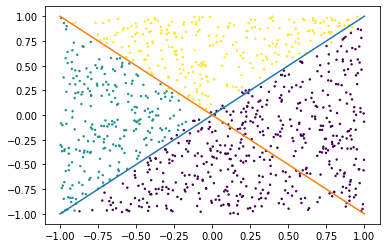

In [154]:
plt.scatter(x[:, 0], x[:, 1], c=y_new, s=2)
plt.plot(np.linspace(-1, 1, 1000), np.linspace(-1,1,1000))
plt.plot(np.linspace(-1, 1, 1000), -np.linspace(-1,1,1000))
plt.show()